DATA LOADING AND SPLITTING

In [1]:
import sys
import os
import warnings

warnings.simplefilter("ignore")

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..', 'proposal')))

from data_distribution.data_loading import *

X,y=load_data("../data/survey_lung_cancer_small.csv")
X, label_encod=preprocess_data_label_encoding(X)
X_train, X_test, y_train, y_test = data_split(X, y,test_size=0.2, random_state=45)

SIMPLE MODEL

Starting XGBoost model training.
XGBoost model trained successfully.
Evaluation results:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.90      0.96      0.93        55

    accuracy                           0.87        63
   macro avg       0.70      0.61      0.63        63
weighted avg       0.85      0.87      0.85        63

Test set accuracy: 0.87


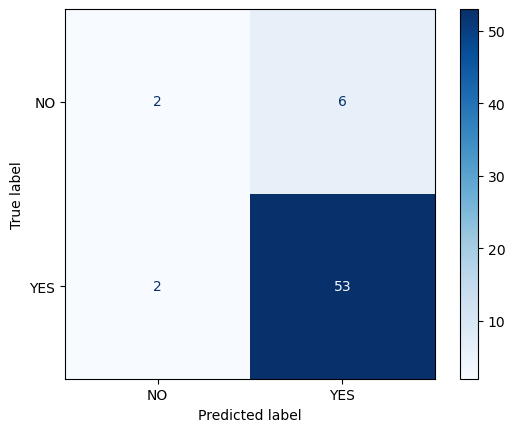

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Add the project path to the import list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..', 'proposal')))

from models.xgboost import *

# Initialize the label encoder and compute class weight for balancing
label_encoder = LabelEncoder()
num_neg = (y_train == 0).sum()  # Number of negative labels
num_pos = (y_train == 1).sum()  # Number of positive labels
scale_pos_weight = num_neg / num_pos if num_pos != 0 else 1

# Encode labels for XGBoost
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Initialize and train the XGBoost model
xgb_model = XGBoostModel(n_estimators=100, max_depth=1, random_state=45, scale_pos_weight=scale_pos_weight)
xgb_model.train(X_train, y_train)

# Evaluate the model on the test set
y_test_pred = xgb_model.predict(X_test)
accuracy_val = xgb_model.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

SMOTE

Starting XGBoost model training.
XGBoost model trained successfully.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.98      0.93      0.95        55

    accuracy                           0.92        63
   macro avg       0.81      0.90      0.85        63
weighted avg       0.94      0.92      0.93        63

Test set accuracy: 0.92


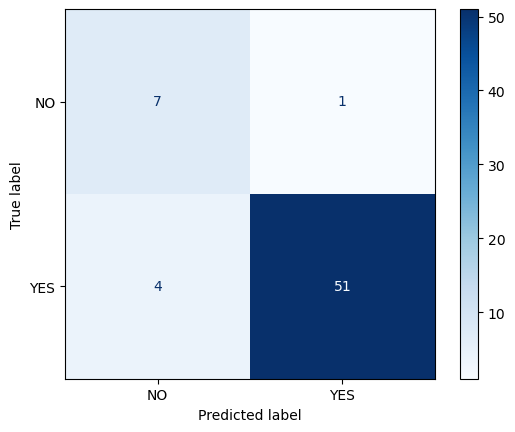

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Apply SMOTE to the training set to handle class imbalance
smote = SMOTE(random_state=45)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost model
xgb_model = XGBoostModel(n_estimators=100, max_depth=1, random_state=45)

# Train the XGBoost model using the balanced dataset
xgb_model.train(X_train_resampled, y_train_resampled)

# Evaluate the XGBoost model
print("\nEvaluation on the test set:")
accuracy_val = xgb_model.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

# Make predictions on the test set
y_test_pred = xgb_model.predict(X_test)

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

CROSS-VALIDATION


Starting hyperparameter tuning...
Fitting 10 folds for each of 54 candidates, totalling 540 fits

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'scale_pos_weight': 1}

Best average accuracy during cross-validation:
0.9495771670190274
Training the optimized model...
Starting XGBoost model training.
XGBoost model trained successfully.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.93      0.96      0.95        55

    accuracy                           0.90        63
   macro avg       0.80      0.73      0.76        63
weighted avg       0.90      0.90      0.90        63

Test set accuracy: 0.90


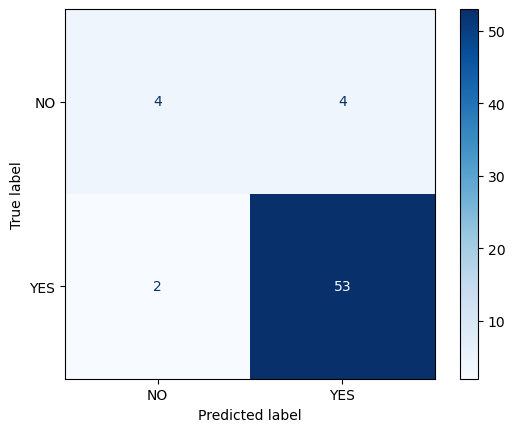

In [4]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the hyperparameter grid for XGBoost tuning
param_grid = {
    'max_depth': [1, 10, 100],             # Regularization parameter
    'n_estimators': [50, 100],             # Number of trees
    'learning_rate': [0.01, 0.1, 0.3],     # Learning rate
    'scale_pos_weight': [1, 2, 3]          # Class weights
}

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=45), 
    param_grid=param_grid, 
    scoring='accuracy',  # Metric to optimize
    cv=10,               # Number of folds for cross-validation
    n_jobs=-1,           # Run in parallel
    verbose=2            # Log the process
)

# Train the model using GridSearchCV
print("\nStarting hyperparameter tuning...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Display the best hyperparameter results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest average accuracy during cross-validation:")
print(grid_search.best_score_)

# Retrieve the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Save the best hyperparameters for future use
best_n_estimators = best_model.n_estimators
best_max_depth = best_model.max_depth
best_learning_rate = best_model.learning_rate
best_scale_pos_weight = best_model.scale_pos_weight

# Create an instance of XGBoostModel using the optimized parameters
xgb_model_optimized = XGBoostModel(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    learning_rate=grid_search.best_params_['learning_rate'],
    scale_pos_weight=grid_search.best_params_['scale_pos_weight']
)

# Train the optimized XGBoost model
print("Training the optimized model...")
xgb_model_optimized.train(X_train_resampled, y_train_resampled)

# Evaluate the optimized model on the test set
print("\nEvaluation on the test set:")
accuracy_val = xgb_model_optimized.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

# Make predictions on the test set
y_test_pred = xgb_model_optimized.predict(X_test)

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

## Feature Engineering

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Principal Component Analysis (PCA) with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Display the variance explained by each PCA component
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance: {explained_variance}")

# Feature engineering: create interaction features
X['Age*Smoking'] = X['AGE'] * X['SMOKING']
X['Chronic*Anxiety'] = X['CHRONIC DISEASE'] * X['ANXIETY']
print("Added interaction features to the dataset.")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Standardize the data after adding the new features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assume that 100 was determined to be the best number of estimators
best_n_estimators = 100  

# Initialize the label encoder and encode labels
label_encoder = LabelEncoder()

num_neg = (y_train == 0).sum()  # Number of negative labels
num_pos = (y_train == 1).sum()  # Number of positive labels
scale_pos_weight = num_neg / num_pos if num_pos != 0 else 1

# Encode labels for XGBoost
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Create an instance of XGBoostModel using the optimized parameters
xgb_model_optimized = XGBoostModel(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    learning_rate=grid_search.best_params_['learning_rate'],
    scale_pos_weight=grid_search.best_params_['scale_pos_weight']
)

# Train the optimized XGBoost model
print("Training the optimized model...")
xgb_model_optimized.train(X_train_scaled, y_train)

# Evaluate the optimized model on the test set
print("\nEvaluation on the test set:")
accuracy_val = xgb_model_optimized.evaluate(X_test_scaled, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

PCA Explained Variance: [0.19006415 0.1292463 ]
Added interaction features to the dataset.
Training the optimized model...
Starting XGBoost model training.
XGBoost model trained successfully.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.91      0.96      0.94        55

    accuracy                           0.89        63
   macro avg       0.76      0.67      0.70        63
weighted avg       0.87      0.89      0.88        63

Test set accuracy: 0.89


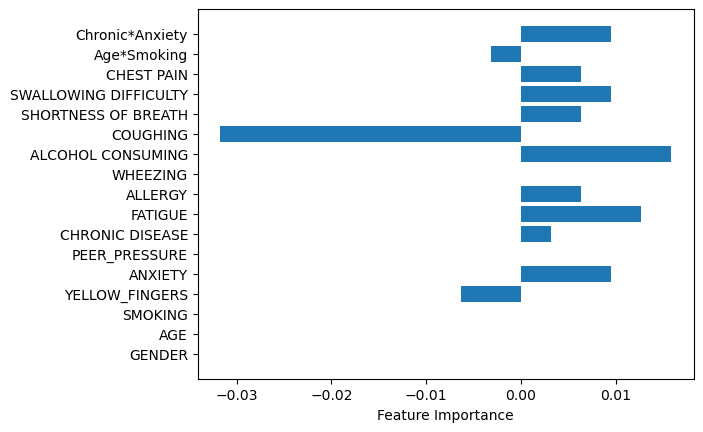

In [6]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance for the model
result = permutation_importance(xgb_model_optimized.model, X_test_scaled, y_test, scoring="accuracy")
feature_importance = result.importances_mean

# Visualize the most important features
plt.barh(range(len(feature_importance)), feature_importance)
plt.yticks(range(len(feature_importance)), X.columns)
plt.xlabel("Feature Importance")
plt.show()